In [27]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve, auc
from pandas.plotting import scatter_matrix
from astroML.classification import GMMBayes




plt.rcParams['figure.figsize'] = (6,4)

# Path to CSV 
csv_path = 'galaxyquasar.csv'

# Load numeric columns and labels
data_header = np.genfromtxt(csv_path, delimiter=',', names=True, usecols=(0,1,2,3,4,6), dtype=float, comments='#')
names = list(data_header.dtype.names)
data_vals = np.genfromtxt(csv_path, delimiter=',', skip_header=1, usecols=(0,1,2,3,4,6), dtype=float)
lab = np.genfromtxt(csv_path, delimiter=',', skip_header=1, usecols=5, dtype=str)

d = dict(zip(names, data_vals.T))
d['lab'] = lab

# Create colors (u-g, g-r, r-i, i-z)
for diff in ['ug','gr','ri','iz']:
    d[diff] = d[diff[0]] - d[diff[1]]

# DataFrame and labels
df = pd.DataFrame({k: d[k] for k in ['u','g','r','i','z','ug','gr','ri','iz']})
df['label_str'] = d['lab']
df['y'] = (df['label_str'] == 'QSO').astype(int)  # galaxy=0, quasar=1

X_all = df[['ug','gr','ri','iz']].values
y_all = df['y'].values

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.33, random_state=67, stratify=y_all)

print('Shapes -> X_train:', X_train.shape, 'X_val:', X_val.shape)


Shapes -> X_train: (33500, 4) X_val: (16500, 4)



## Visualize data

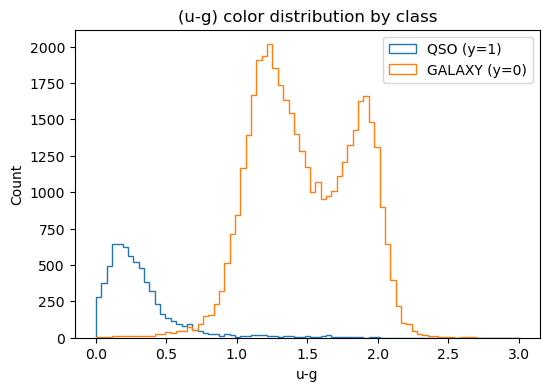

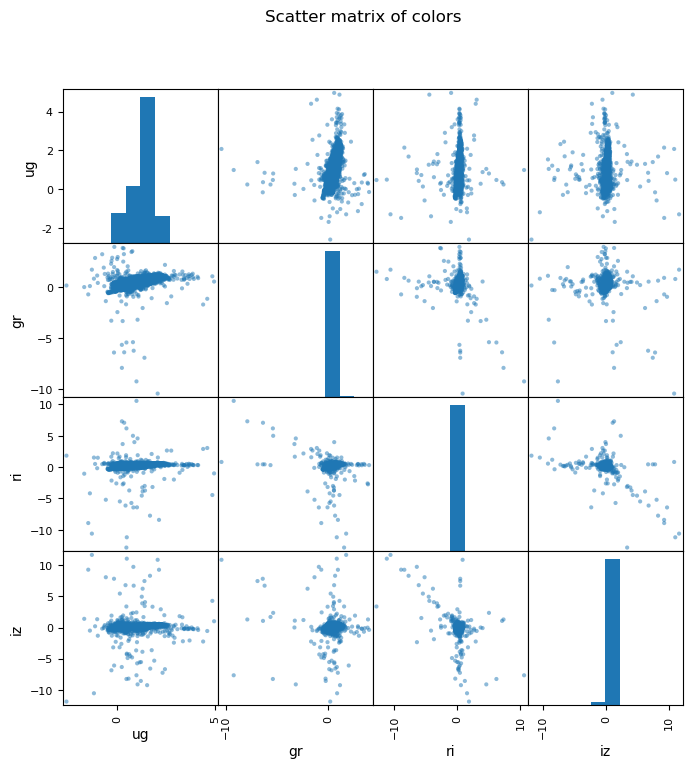

In [28]:

# (u-g) by class
bins = np.linspace(0, 3, 80)
plt.figure()
plt.hist(df.loc[df['y']==1,'ug'], bins=bins, histtype='step', label='QSO (y=1)')
plt.hist(df.loc[df['y']==0,'ug'], bins=bins, histtype='step', label='GALAXY (y=0)')
plt.legend()
plt.title("(u-g) color distribution by class")
plt.xlabel("u-g"); plt.ylabel("Count"); plt.show()

# scatter matrix 
scatter_matrix(df[['ug','gr','ri','iz']], figsize=(8,8), diagonal='hist')
plt.suptitle("Scatter matrix of colors")
plt.show()



### Check for the "Naive" assumption (Naive Bayes assumes conditional independence of features given the class)


Correlation matrix among colors:
           ug        gr        ri        iz
ug  1.000000  0.803315  0.469237  0.360335
gr  0.803315  1.000000  0.347712  0.318454
ri  0.469237  0.347712  1.000000 -0.158128
iz  0.360335  0.318454 -0.158128  1.000000


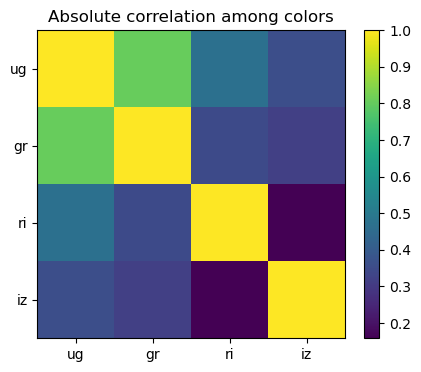

In [29]:

corr = df[['ug','gr','ri','iz']].corr()
print('Correlation matrix among colors:\n', corr)

plt.figure()
im = plt.imshow(np.abs(corr.values), interpolation='nearest')
plt.xticks(range(4), ['ug','gr','ri','iz'])
plt.yticks(range(4), ['ug','gr','ri','iz'])
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Absolute correlation among colors")
plt.show()



## Models and ROC/AUC

Compare the following classifiers on incremental feature sets:
1. `[ug]`
2. `[ug, gr]`
3. `[ug, gr, ri]`
4. `[ug, gr, ri, iz]`

In [ ]:


feature_names = ['ug','gr','ri','iz']  
blocks = [1, 2, 3, 4]                  

#grids
k_grid   = [1, 3, 5, 7, 9, 11, 15, 21, 31]
n_grid   = np.arange(2, 20, 2)

#results
rows = []
roc_store = {}  

#Incremental feautures
for k_feats in blocks:
    idx = list(range(k_feats))
    Xtr, Xte = X_train[:, idx], X_val[:, idx]
    feat_label = "+".join(feature_names[:k_feats])

    #Models without hyperparameters tuning
    for name, clf in [
        ("Gaussian Naive Bayes", GaussianNB()),
        ("Linear Discriminant Analysis", LinearDiscriminantAnalysis()),
        ("Quadratic Discriminant Analysis", QuadraticDiscriminantAnalysis()),
    ]:
        clf.fit(Xtr, y_train) #train
        y_prob = clf.predict_proba(Xte)[:, 1] #probability of be of the 1st class
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        AUC = auc(fpr, tpr)
        rows.append({"Features": feat_label, "Model": name, "Param": "-", "AUC": AUC})
        roc_store[(k_feats, name)] = (fpr, tpr, AUC, "-")

    #k-NN: sweep on k to choose the best value of the hyperparameter
    best_k, best_auc_knn, best_curve_knn = None, -np.inf, None
    for k in k_grid:
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(Xtr, y_train)
        y_prob = clf.predict_proba(Xte)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        AUC = auc(fpr, tpr)
        if AUC > best_auc_knn:
            best_auc_knn = AUC
            best_k = k
            best_curve_knn = (fpr, tpr)
    #Save the one with the best hp
    rows.append({"Features": feat_label, "Model": "k-NN (tuned)", "Param": f"k={best_k}", "AUC": best_auc_knn})
    roc_store[(k_feats, "k-NN (tuned)")] = (*best_curve_knn, best_auc_knn, f"k={best_k}")

    #GMM Bayes: sweep on n_components to choose the best value of the hyperparameter
    best_n, best_auc_gmm, best_curve_gmm = None, -np.inf, None
    for n_comp in n_grid:
        clf = GMMBayes(n_components=n_comp)
        clf.fit(Xtr, y_train)
        y_prob = clf.predict_proba(Xte)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        AUC = auc(fpr, tpr)
        if AUC > best_auc_gmm:
            best_auc_gmm = AUC
            best_n = n_comp
            best_curve_gmm = (fpr, tpr)
    #Save the one with the best hp
    rows.append({"Features": feat_label, "Model": "GMM Bayes (tuned)", "Param": f"n={best_n}", "AUC": best_auc_gmm})
    roc_store[(k_feats, "GMM Bayes (tuned)")] = (*best_curve_gmm, best_auc_gmm, f"n={best_n}")

# AUC table for each models and feautures considered
res_df = pd.DataFrame(rows).sort_values(["Features","AUC"], ascending=[True, False]).reset_index(drop=True)
print(res_df)


       Features                            Model Param       AUC
0            ug                GMM Bayes (tuned)  n=18  0.984950
1            ug                     k-NN (tuned)  k=31  0.980662
2            ug     Linear Discriminant Analysis     -  0.980360
3            ug  Quadratic Discriminant Analysis     -  0.980360
4            ug             Gaussian Naive Bayes     -  0.980360
5         ug+gr                GMM Bayes (tuned)   n=8  0.990695
6         ug+gr                     k-NN (tuned)  k=31  0.984770
7         ug+gr  Quadratic Discriminant Analysis     -  0.981237
8         ug+gr     Linear Discriminant Analysis     -  0.980809
9         ug+gr             Gaussian Naive Bayes     -  0.977909
10     ug+gr+ri                GMM Bayes (tuned)   n=8  0.991846
11     ug+gr+ri                     k-NN (tuned)  k=31  0.986630
12     ug+gr+ri  Quadratic Discriminant Analysis     -  0.980505
13     ug+gr+ri     Linear Discriminant Analysis     -  0.980445
14     ug+gr+ri          

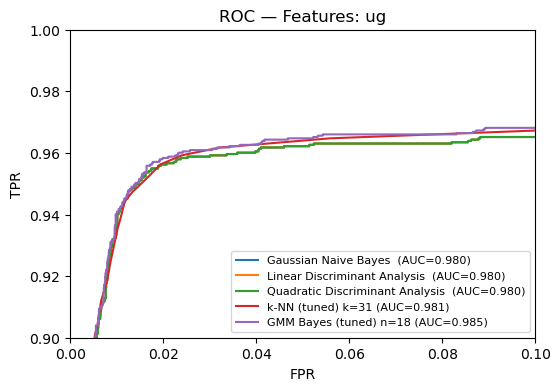

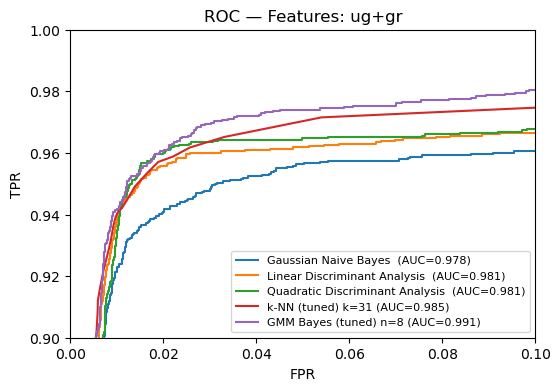

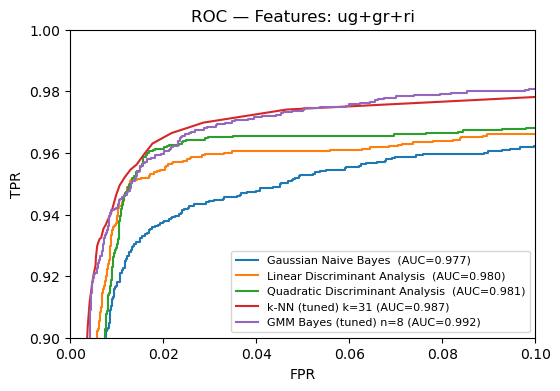

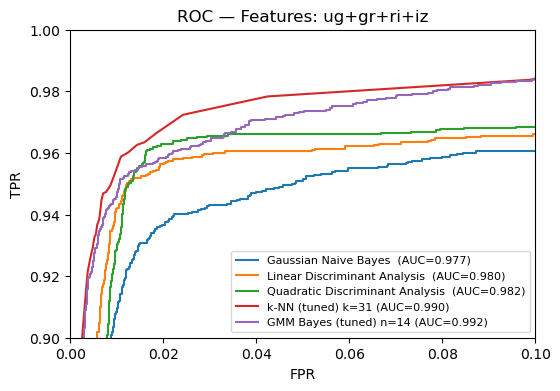

In [32]:

#ROC curves of the models with different number of features
for k_feats in blocks:
    feat_label = "+".join(feature_names[:k_feats])
    plt.figure()
    for name in ["Gaussian Naive Bayes", "Linear Discriminant Analysis",
                 "Quadratic Discriminant Analysis", "k-NN (tuned)", "GMM Bayes (tuned)"]:
        fpr, tpr, AUC, extra = roc_store[(k_feats, name)]
        lab = f"{name} {extra if extra!='-' else ''} (AUC={AUC:.3f})".strip()
        plt.plot(fpr, tpr, label=lab)
    plt.plot([0,1],[0,1],'--',lw=1)
    plt.title(f"ROC — Features: {feat_label}")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.xlim(0, 0.1); plt.ylim(0.9, 1.0)
    plt.legend(loc="lower right", fontsize=8)
    plt.show()



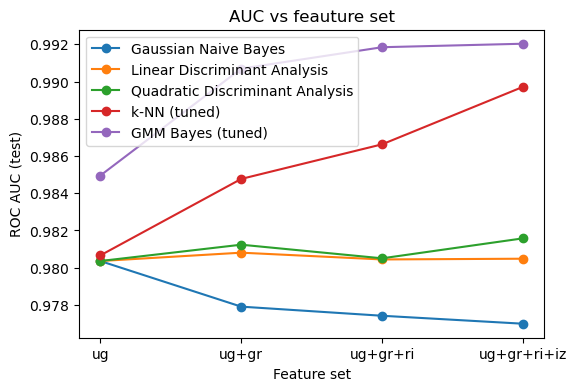

In [34]:

# AUC vs number of features
plt.figure()
models_order = ["Gaussian Naive Bayes","Linear Discriminant Analysis","Quadratic Discriminant Analysis",
                "k-NN (tuned)","GMM Bayes (tuned)"]

for name in models_order:
    xs, ys = [], []
    for k_feats in blocks:
        _, _, AUC, _ = roc_store[(k_feats, name)]
        xs.append(k_feats)
        ys.append(AUC)
    plt.plot(xs, ys, marker='o', label=name)

plt.xticks(blocks, ['ug','ug+gr','ug+gr+ri','ug+gr+ri+iz'])
plt.xlabel("Feature set")
plt.ylabel("ROC AUC (test)")
plt.title("AUC vs feauture set")
plt.legend()
plt.show()
